In [3]:
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import pandas as pd
# import altair as alt

from time import time
import pickle

In [2]:
def create_data(n_feats=8, n_obs=1000):
    features = ('f' + str(x) for x in range(n_feats))
    target = abs(np.random.normal(1000, 250, n_obs))
    feat_vals = []
    for feature in features:
        feat_vals.append(np.fromiter((np.random.normal(
                            abs(np.random.normal(target[i],
                            abs(np.random.normal(100, 30)))))
                            for i in range(n_obs)), dtype='float'))
    X = np.array(feat_vals).T
    return X, target

In [2]:
class NormalEquation:
    
    def __init__(self):
        pass
    
    def __repr__(self):
        return "OLS()"
    
    def fit(self, X_train, y_train):
        # Our new column that we'll call intercept
        # We make it based on the shape of the first column in our training data
        intercept = np.ones_like(X_train[:, 0])
        
        # We add our new column to our training data and create a new variable
        X_train_int = np.insert(X_train, 0, intercept, axis=1)
        
        # Use the normal equation
        # (X_train_int.T @ X_train_int)^-1 = ((k x n) @ (n x k))^-1 -> k x k
        # X_train_int.T = (k x n)
        # y_train = (n x 1)
        # coefs = (k x k) @ (k x n) @ (n x 1) -> k x 1
        coefs = np.linalg.inv(X_train_int.T @ X_train_int) @ X_train_int.T @ y_train
        
        # Save our coefficients for later use
        self.coefs_ = coefs
        return self
    
    def predict(self, X_test):
        # Again, we create a new column for the test data
        intercept = np.ones_like(X_test[:, 0])
        X_test_int = np.insert(X_test, 0, intercept, axis=1)
        
        # preds = (n x k) @ (k x 1) = n x 1
        preds = X_test_int @ self.coefs_
        return preds
    
    def score(self, X_test, y_test):
        # Again, we create a new column for the test data
        intercept = np.ones_like(X_test[:, 0])
        X_test_int = np.insert(X_test, 0, intercept, axis=1)

        # preds = (n x k) @ (k x 1) = n x 1
        preds = X_test_int @ self.coefs_
        
        # Here we're simply calculating r-squared
        score = 1 - ((y_test - preds)**2).sum() / ((y_test - y_test.mean())**2).sum()
        return score

In [3]:
X, target = create_data(5_000, 5_000)

In [ ]:
for _ in range(5):
    new_feats = ('f' + str(x) for x in range(X.shape[1]))
    new_targs = abs(np.random.normal(1_000, 250, 5_000))
    new_feat_vals = []
    for feature in new_feats:
        new_feat_vals.append(np.fromiter((np.random.normal(
                            abs(np.random.normal(new_targs[i],
                            abs(np.random.normal(100, 30)))))
                            for i in range(5_000)), dtype='float'))
    new_X = np.array(new_feat_vals).T
    new_X = minmax_scale(new_X)

    # Add features for new observations
    X = np.append(X, new_X, axis=0)

    # Add new target for new observations
    target = np.append(target, new_targs, axis=0)

    # Creates new features for new and existing observations
    new_feats = ('f' + str(x) for x in range(5_000))
    new_feat_vals = []
    for feature in new_feats:
        new_feat_vals.append(np.fromiter((np.random.normal(
                            abs(np.random.normal(target[i],
                            abs(np.random.normal(100, 30)))))
                            for i in range(target.shape[0])), dtype='float'))
    new_X = np.array(new_feat_vals).T
    new_X = minmax_scale(new_X)

    # Add new features to modifed matrix
    X = np.append(X, new_X, axis=1)

    t_X = pd.DataFrame(X)
    t_y = pd.DataFrame(target)
    data = pd.concat([t_X, t_y], axis=1)
    data.to_csv("Data/X_y_"+str(data.shape[0])+".csv")

In [4]:
df = pd.read_csv('Data/X_y_30000.pkl', index_col=0)

In [8]:
target = df.iloc[:, -1].values
X = df.iloc[:, :-1].values

In [ ]:
start = time()
NormalEquation().fit(X[:15_000, :19_999], target[:15_000])
end = time()
print(end - start)

start = time()
LinearRegression().fit(X[:15_000, :19_999], target[:15_000])
end = time()
print(end - start)

start = time()
LinearRegression(n_jobs=-1).fit(X[:15_000, :19_999], target[:15_000])
end = time()
print(end - start)

In [ ]:
sizes_sq = np.linspace(1_000, 900_000_000, 50)
indices = map(int, map(np.sqrt, sizes_sq))

In [ ]:
norml_equat_time = []
sklrn_model_time = []
sklrn_njms1_time = []

for i in indices:
    
    # Sublists for taking average run-time
    norml_equat_time_sub = []
    sklrn_model_time_sub = []
    sklrn_njms1_time_sub = []

    for _ in range(3):

        start = time()
        NormalEquation().fit(X[:i, :i-1], target[:i])
        end = time()
        norml_equat_time_sub.append(end - start)

        start = time()
        LinearRegression().fit(X[:i, :i-1], target[:i])
        end = time()
        sklrn_model_time_sub.append(end - start)
        
        start = time()
        LinearRegression(n_jobs=-1).fit(X[:i, :i-1], target[:i])
        end = time()
        sklrn_njms1_time_sub.append(end - start)

    # Add average time to list
    norml_equat_time.append(sum(norml_equat_time_sub)/3)
    sklrn_model_time.append(sum(sklrn_model_time_sub)/3)
    sklrn_njms1_time.append(sum(sklrn_njms1_time_sub)/3)
    
    # Save results for each iteration in the event the loop
    # terminates early
    results = [norml_equat_time, sklrn_model_time, sklrn_njms1_time]
    results_name = "Data/results_%s.pkl" % str(target.shape[0])
    
    file = open(results_name, "wb")
    pickle.dump(results, file)
    file.close()
    
    print(time())

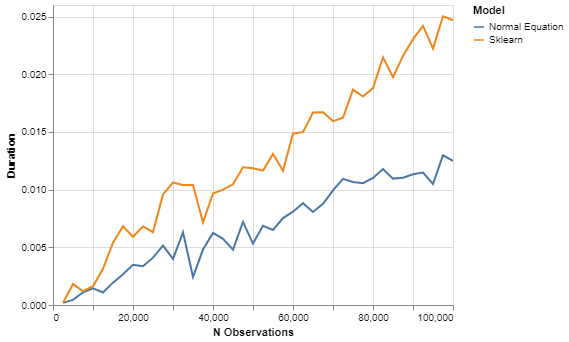

In [52]:

x = np.arange(100)
source = pd.DataFrame({
    'Duration': normal_equation + sklearn_LinRegr,
    'Model':['Normal Equation'] * 40 + ['Sklearn'] * 40,
    'N Observations': list(n_observations) * 2
})

alt.Chart(source).mark_line().encode(
    x='N Observations',
    y='Duration',
    color='Model'
)
